# Stroke Prediction
Stroke is the 2nd highest cause of mortality in the world (WHO). Even if an individual survives a stroke, it is common that the individual has severe symptoms such as spasticity, cognitive problems etc.

Since stroke is a major health problem, it is crucial to know the risk factors that cause a stroke.In this dataset, we will investigate these factors and build a model that predicts stroke.

The data set contains 11 features and 1 target variable. The target variable is 'Stroke' column, which is binary data 0: No stroke, 1 : Stroke.  

Anyway, let's start digging.


#### Importing packages 

In [255]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from scipy import stats
sns.set()
pd.set_option('display.max_columns', 60)


import warnings
warnings.filterwarnings("ignore")

In [256]:

# Read the csv file
df = pd.read_csv('https://raw.githubusercontent.com/orkunaran/Stroke-Prediction/main/healthcare-dataset-stroke-data.csv?token=ATQ2GJQAQVXBH2NBTS4PC3LBEFO6S')

In [257]:
# First and last 5 rows of the data
display(df.head())
df.tail()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0
5109,44679,Female,44.0,0,0,Yes,Govt_job,Urban,85.28,26.2,Unknown,0


In [258]:
print('The Stroke data has {0} rows and {1} columns'.format(df.shape[0],df.shape[1]))

The Stroke data has 5110 rows and 12 columns


Let's see;
The data consists of 5110 rows and 12 columns. The first column is 'ID' column, we might want to remove this. Then, the other columns seems to be categorical variables except Age, glucose level and BMI. We will get the info of the data, just in case if there is any unsuitable types.

After that, we should investigate missing values if there is any; and see the proportion of the missings.

## Investigating Target Variable

In [259]:
# Since this is a classification problem, let's investigate the proportion of stroke variables.
df['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

4861 vs 249. We have Class Imbalance here. From what I learnt (tnx google and youtube),  We can use Spread SubSampling or  Synthetic Minority Over-sampling Technique (SMOTE). Spread SubSampling means that we will delete some rows which had 0 (no stroke) value. However I don't think this is a good idea for this dataset, because the number of  participants with stroke is 227; and we need to delete nearly 4400 rows. So I think it is better to use SMOTE and have a decent number of data

We'll handle this after dealing with missings.

In [260]:
# remove Id columns and investigate column types
df = df.drop(['id'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


The data types seem good. No changes needed

In [261]:
# investigate the means, medians, min-max of the data.
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


Age column seem to have an issue. 0.08 years of age might be wrong, we'll dive into that.  Also, 10 BMI would be wrong too, but we need to see if it's ok or not. I really wished that data had weight an height informations as well.

In [262]:
missings = pd.DataFrame(columns=['Columns','Missing','Percentage'])

In [263]:
for x in df.columns:
    if df[x].isna().sum() >0:
        missings = missings.append({'Columns': x ,'Missing': df[x].isna().sum(), 
                                    'Percentage':(df[x].isna().sum()/len(df[x])*100)}, ignore_index=True)

In [264]:
missings

,Columns,Missing,Percentage
0,bmi,201,3.933464


only BMI column has missings and it's really a low proportion of the data. We will use KNN imputation to predict the missings , or easily we will fill them with means; but i want to learn KNN here, so I will use it :)

In [265]:
#first import KNN imputer
from sklearn.impute import KNNImputer

In [266]:
# check the describe line for the mean of the BMI
#mean 28 std 7.8

In [267]:
imputer = KNNImputer(n_neighbors=5)
imputed = pd.DataFrame(imputer.fit_transform(df.iloc[:,[1,7,8,10]]), columns=['age','avg_glucose_levels','bmi','stroke'])



basicly we imputed BMI values accoring to the neigborhoods; KNN imputer will get nearest 5 columns according to age, avg_glucose_levels and stroke; and returned their means for the missing rows.

In [268]:
# lets see if the mean was changed
display(imputed.describe())
imputed.info()

,age,avg_glucose_levels,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000
mean,43.226614,106.147677,28.943076,0.048728
std,22.612647,45.283560,7.765971,0.215320
min,0.080000,55.120000,10.300000,0.000000
25%,25.000000,77.245000,23.700000,0.000000
50%,45.000000,91.885000,28.200000,0.000000
75%,61.000000,114.090000,33.075000,0.000000
max,82.000000,271.740000,97.600000,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age                 5110 non-null   float64
 1   avg_glucose_levels  5110 non-null   float64
 2   bmi                 5110 non-null   float64
 3   stroke              5110 non-null   float64
dtypes: float64(4)
memory usage: 159.8 KB


We have no missing, and mean and std seems not changed ( we can ignore the changes on the decimals).
Change BMI column of the df data.

In [269]:
df['bmi'] = imputed['bmi']

In [270]:
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.60,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,31.38,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.50,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.40,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.00,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,26.82,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.00,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.60,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.60,formerly smoked,0


#### Creating new features: 
has_diabetes and 
is_obese

According to DSM VI glucose lvl above 126 accepted as diabetes mellitus.

BMI > 30 is obese

In [271]:
df['has_diabetes'] = [(1 if i >125 else 0) for i in df['avg_glucose_level']] 
df['is_obese'] = [1 if i>=30 else 0 for i in df['bmi']]

In [272]:
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,has_diabetes,is_obese
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.60,formerly smoked,1,1,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,31.38,never smoked,1,1,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.50,never smoked,1,0,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.40,smokes,1,1,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.00,never smoked,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,26.82,never smoked,0,0,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.00,never smoked,0,1,1
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.60,never smoked,0,0,1
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.60,formerly smoked,0,1,0


## Outlier detection 

In [273]:
# possible outliers are in Age and BMI columns as mentioned above. 

In [274]:
# Reference to Ceren İyim github, link : https://github.com/cereniyim/Tree-Classification-ML-Model
def outlier_function(df, col_name):
    ''' this function detects first and third quartile and interquartile range for a given column of a dataframe
    then calculates upper and lower limits to determine outliers conservatively
    returns the number of lower and uper limit and number of outliers respectively
    '''
    first_quartile = np.percentile(df[col_name], 25)
    third_quartile = np.percentile(df[col_name], 75)
    IQR = third_quartile - first_quartile
                      
    upper_limit = third_quartile+(1.5*IQR)
    lower_limit = first_quartile-(1.5*IQR)
    outlier_count = 0
                      
    for value in df[col_name].tolist():
        if (value < lower_limit) | (value > upper_limit):
            outlier_count +=1
    return lower_limit, upper_limit, outlier_count

In [275]:
numerics= df.select_dtypes(include='float64')
for column in numerics.columns:
    if outlier_function(numerics, column)[2] > 0:
        print("There are {} outliers in {}".format(outlier_function(df, column)[2], column))

There are 627 outliers in avg_glucose_level
There are 117 outliers in bmi


In [276]:
#I want to investigate age columns additionally, although there was no outliers detected. The ages below 1 may be problem
age_invest = df[df['work_type']=='children']
display(age_invest)
age_invest.describe()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,has_diabetes,is_obese
162,Female,1.32,0,0,No,children,Urban,70.37,17.06,Unknown,1,0,0
245,Female,14.00,0,0,No,children,Rural,57.93,30.90,Unknown,1,0,1
249,Male,3.00,0,0,No,children,Rural,95.12,18.00,Unknown,0,0,0
282,Female,3.00,0,0,No,children,Urban,73.74,16.00,Unknown,0,0,0
290,Male,13.00,0,0,No,children,Urban,114.84,18.30,Unknown,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5089,Female,0.72,0,0,No,children,Rural,62.13,16.80,Unknown,0,0,0
5094,Male,13.00,0,0,No,children,Urban,82.38,24.30,Unknown,0,0,0
5095,Male,1.08,0,0,No,children,Rural,79.15,17.40,Unknown,0,0,0
5098,Male,9.00,0,0,No,children,Urban,71.88,17.50,Unknown,0,0,0


,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,has_diabetes,is_obese
count,687.000000,687.0,687.000000,687.000000,687.000000,687.000000,687.000000,687.000000
mean,6.841339,0.0,0.001456,94.400277,20.042096,0.002911,0.106259,0.043668
std,4.533364,0.0,0.038152,26.658955,4.500349,0.053916,0.308393,0.204505
min,0.080000,0.0,0.000000,55.340000,10.300000,0.000000,0.000000,0.000000
25%,2.000000,0.0,0.000000,76.255000,17.200000,0.000000,0.000000,0.000000
50%,6.000000,0.0,0.000000,90.220000,18.900000,0.000000,0.000000,0.000000
75%,11.000000,0.0,0.000000,108.710000,21.600000,0.000000,0.000000,0.000000
max,16.000000,0.0,1.000000,219.810000,41.700000,1.000000,1.000000,1.000000


It is obvious that I was wrong about the age issue; the ages below 0 is months converted to years, and these values are children's data. So I would keep age data as it is

TLDR: age columns is good, back to outlier removal.

In [277]:
# I'm going to remove outliers by glucose levels in which we had 166 outliers.
df = df[(df['avg_glucose_level'] > outlier_function(df, 'avg_glucose_level')[0]) &
              (df['avg_glucose_level'] < outlier_function(df, 'avg_glucose_level')[1])]


In [278]:
df.shape

(4483, 13)

In [279]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,has_diabetes,is_obese
count,4483.000000,4483.00000,4483.000000,4483.000000,4483.000000,4483.000000,4483.000000,4483.000000
mean,40.886317,0.07495,0.038590,91.435077,28.326014,0.036806,0.083203,0.361365
std,22.389719,0.26334,0.192638,22.635346,7.572903,0.188305,0.276220,0.480450
min,0.080000,0.00000,0.000000,55.120000,10.300000,0.000000,0.000000,0.000000
25%,23.000000,0.00000,0.000000,75.060000,23.200000,0.000000,0.000000,0.000000
50%,42.000000,0.00000,0.000000,87.960000,27.700000,0.000000,0.000000,0.000000
75%,58.000000,0.00000,0.000000,103.930000,32.300000,0.000000,0.000000,1.000000
max,82.000000,1.00000,1.000000,168.680000,97.600000,1.000000,1.000000,1.000000


Outliers done, now it is time to do some visualization

In [280]:
#Before graphs, lets see the means of the two groups (stroke and healthy)

means = df.loc[:,['age','avg_glucose_level','bmi','stroke']]
counts = df.loc[:,['gender', 'hypertension','heart_disease','ever_married','work_type','Residence_type','smoking_status',
                  'has_diabetes','is_obese','stroke']]
display(df['stroke'].value_counts())
display(means.groupby(means['stroke']).mean())
display(counts.groupby(counts['stroke']).sum())

0    4318
1     165
Name: stroke, dtype: int64

,age,avg_glucose_level,bmi
stroke,,,
0,39.896489,91.420956,28.306063
1,66.789818,91.804606,28.848121


,hypertension,heart_disease,has_diabetes,is_obese
stroke,,,,
0,299,152,357,1560
1,37,21,16,60


People who had a stroke is older, has higher blood sugar rates and slightly higher BMI. 

In [281]:
print('the percentage of stroke in the data set is :', sum(df['stroke']==1)*100/len(df))

the percentage of stroke in the data set is : 3.6805710461744368


According to Global burden disease reports Stroke prevelance in the world is 1,180.40 per 100,000 population. Which is 1.12%. 

Reference: https://www.world-stroke.org/assets/downloads/WSO_Fact-sheet_15.01.2020.pdf

However, to make appropriate predictions, we need more data from Stroke feature. As mentioned above I will use SMOTE to estimate/create more data.


## Data Visualition

### All data visuals

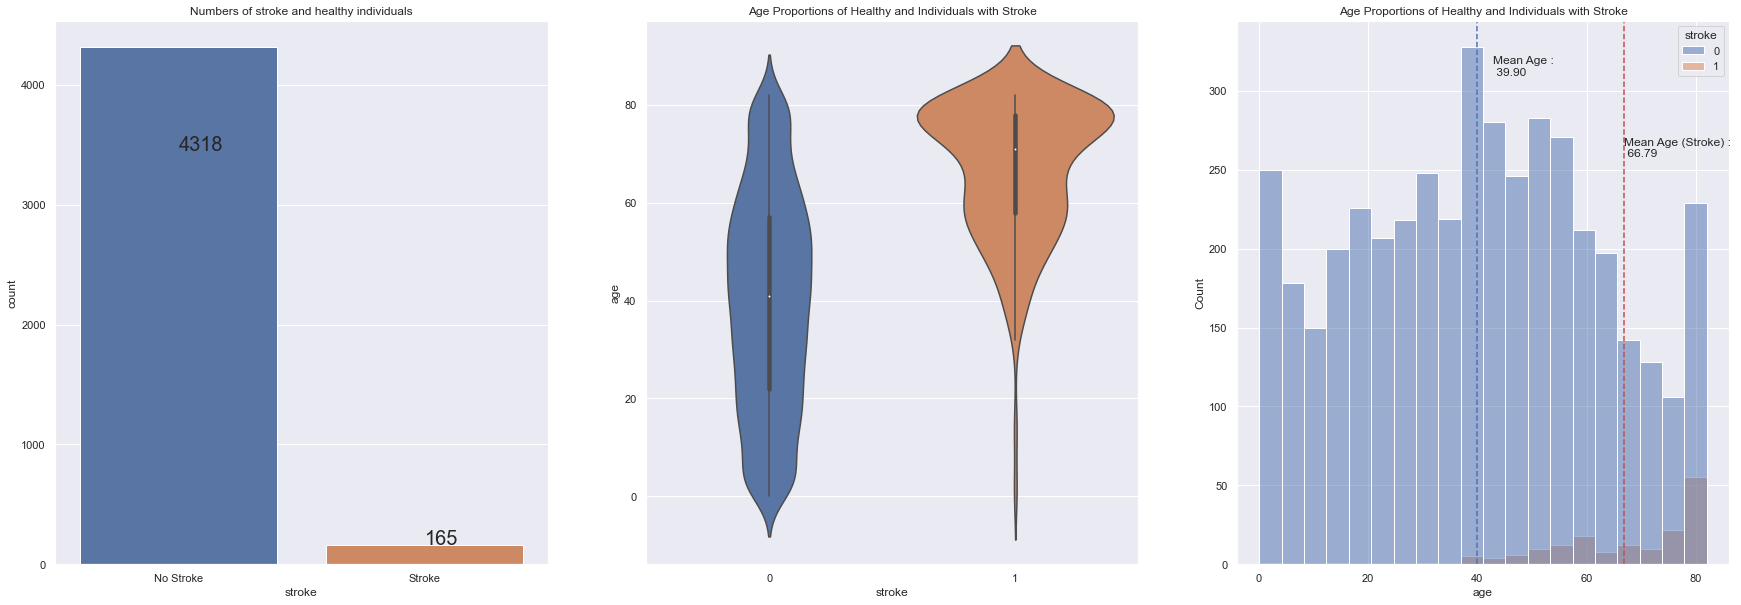

In [282]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(30,10))

sns.countplot(df['stroke'], ax = ax1)
ax1.set_xticklabels( ['No Stroke', 'Stroke'])
ax1.set_title('Numbers of stroke and healthy individuals')
ax1.text( s = df['stroke'].value_counts()[0],
         x = 0,
         y = (df['stroke'].value_counts()[0]) * 0.8,
        fontsize = 20)

ax1.text( s = df['stroke'].value_counts()[1],
         x = 1,
         y = (df['stroke'].value_counts()[1]),
        fontsize = 20)

sns.violinplot(x=df['stroke'], y=df['age'], ax = ax2)
ax2.set_title('Age Proportions of Healthy and Individuals with Stroke')


sns.histplot(data = df, x = 'age', hue='stroke', ax = ax3)
miny_lim, y_lim = plt.ylim()
ax3.axvline(df[df['stroke']==1]['age'].mean(), linestyle='--', color='r')
ax3.axvline(df[df['stroke']==0]['age'].mean(), linestyle='--')
ax3.text(s = f"Mean Age (Stroke) : \n {df[df['stroke']==1]['age'].mean():.2f}",
         y = y_lim * 0.75, x =df[df['stroke']==1]['age'].mean() )
ax3.text(s = f"Mean Age : \n {df[df['stroke']==0]['age'].mean():.2f}",
         y = y_lim * 0.9, x =df[df['stroke']==0]['age'].mean()+3 )
ax3.set_title('Age Proportions of Healthy and Individuals with Stroke')

plt.show()

It seems, stroke is morelikely to occur at older ages. (yes, i know this is too obvious)

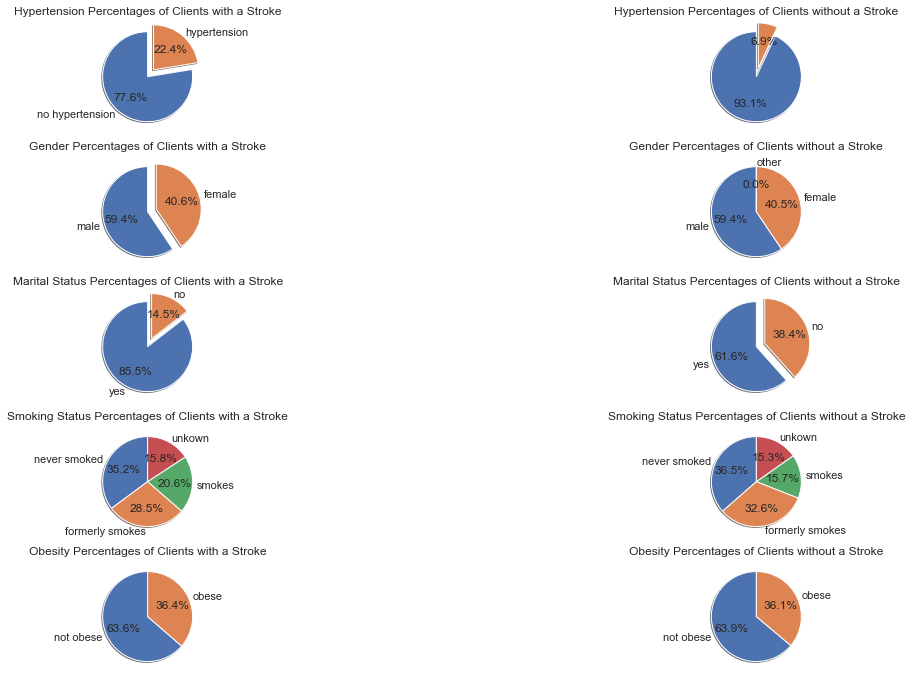

In [283]:
strokes = df[df['stroke']==1]
no_stroke = df[df['stroke']==0]
fig, ax = plt.subplots(5,2, figsize=(20,12))

ax[0,0].pie(strokes['hypertension'].value_counts(normalize=True),
           autopct= '%1.1f%%',
           shadow = True,
            labels = ['no hypertension', 'hypertension'],
           startangle = 90,
           explode = [0,0.2])
ax[0,0].set_title('Hypertension Percentages of Clients with a Stroke')

ax[0,1].pie(no_stroke['hypertension'].value_counts(normalize=True),
           autopct= '%1.1f%%',
           shadow = True,
           startangle = 90,
           explode = [0,0.2])
ax[0,1].set_title('Hypertension Percentages of Clients without a Stroke')

ax[1,0].pie(strokes['gender'].value_counts(normalize=True),
           autopct= '%1.1f%%',
           shadow = True,
           labels = ['male', 'female'],
           startangle = 90,
           explode = [0,0.2])
ax[1,0].set_title('Gender Percentages of Clients with a Stroke')

ax[1,1].pie(no_stroke['gender'].value_counts(normalize=True),
           autopct= '%1.1f%%',
           shadow = True,
            labels = ['male', 'female', 'other'],
           startangle = 90,
           )
ax[1,1].set_title('Gender Percentages of Clients without a Stroke')


ax[2,0].pie(strokes['ever_married'].value_counts(normalize=True),
           autopct= '%1.1f%%',
           shadow = True,
            labels = ['yes', 'no'],
           startangle = 90,
           explode = [0,0.2])
ax[2,0].set_title('Marital Status Percentages of Clients with a Stroke')


ax[2,1].pie(no_stroke['ever_married'].value_counts(normalize=True),
           autopct= '%1.1f%%',
           shadow = True,
            labels = ['yes', 'no'],
           startangle = 90,
           explode = [0,0.2])
ax[2,1].set_title('Marital Status Percentages of Clients without a Stroke')

ax[3,0].pie(strokes['smoking_status'].value_counts(normalize=True),
           autopct= '%1.1f%%',
           shadow = True,
           labels = ['never smoked', 'formerly smokes', 'smokes','unkown'],
           startangle = 90,
           #explode = [0,0.2]
           )
ax[3,0].set_title('Smoking Status Percentages of Clients with a Stroke')

ax[3,1].pie(no_stroke['smoking_status'].value_counts(normalize=True),
           autopct= '%1.1f%%',
           shadow = True,
          labels = ['never smoked', 'formerly smokes', 'smokes','unkown'],
           startangle = 90,
           #explode = [0,0.2]
           )
ax[3,1].set_title('Smoking Status Percentages of Clients without a Stroke')

ax[4,0].pie(strokes['is_obese'].value_counts(normalize=True),
           autopct= '%1.1f%%',
           shadow = True,
           labels = ['not obese', 'obese'],
           startangle = 90,
           #explode = [0,0.2]
           )
ax[4,0].set_title('Obesity Percentages of Clients with a Stroke')

ax[4,1].pie(no_stroke['is_obese'].value_counts(normalize=True),
           autopct= '%1.1f%%',
           shadow = True,
            labels = ['not obese', 'obese'],
           startangle = 90,
           #explode = [0,0.2]
           )
ax[4,1].set_title('Obesity Percentages of Clients without a Stroke')


plt.show()

## Observations of Plots

As we can see from the pie charts;

* Clients with a stroke has higher hypertension rates than the clients with no stroke

* We cannot tell anything from the gender distrubitions; however according to literature Male gender has higher chance to have a stroke 

* Let's make a bias here : IF YOU ARE MARRIED, YOU ARE MORE LIKELY TO HAVE A STROKE :) 
        
        Well it is hard to say that. 
        
        Let's recall the histogram that we plot for age distributions. The clients with stroke had higher age means than the clients with no stroke. 
        It is more likely someone to get married after a certain age.  So , I wouldn't say that marriage affects the possibility to have a stroke or not.
        
* Nearly all groups has similar proportions, however smokers are higher in the ones had a stroke. And again, it is hard to conclude 'Smoking increases your chances to have a stroke' from this dataset. 

* And yet again, we cannot make an assumption from the obesity levels. Maybe we can create labels from obesity data. 

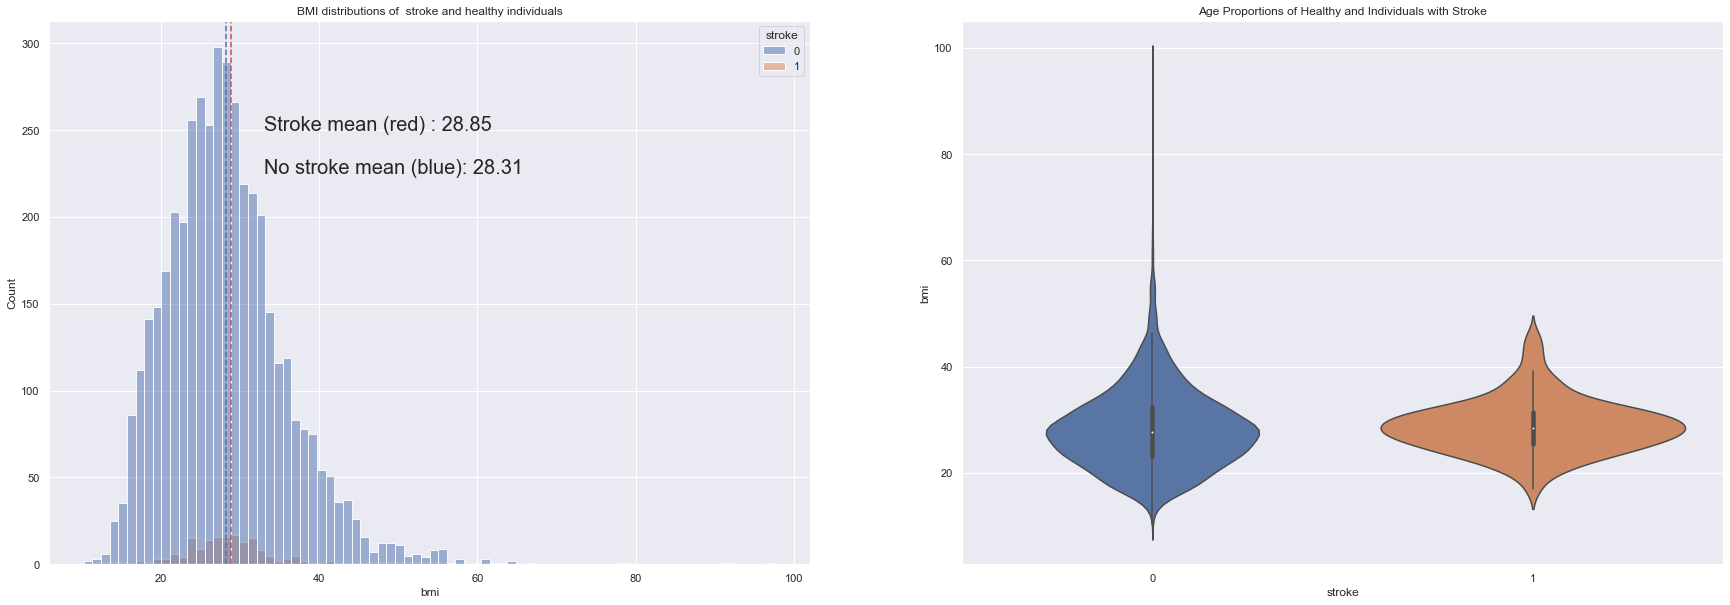

In [284]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(30,10))

sns.histplot(data = df, x= 'bmi', hue= 'stroke', ax = ax1)
ax1.set_title('BMI distributions of  stroke and healthy individuals')
ax1.text( s = 'Stroke mean (red) : ' "{:.2f}".format(strokes['bmi'].mean()),
         x = 33,
         y = 250,
       fontsize = 20)

ax1.text( s = 'No stroke mean (blue): ' "{:.2f}".format(no_stroke['bmi'].mean()),
         x = 33,
         y = 225,
       fontsize = 20)
ax1.axvline(strokes['bmi'].mean(), linestyle='--', color='r')
ax1.axvline(no_stroke['bmi'].mean(), linestyle='--', color='b')

sns.violinplot(x=df['stroke'], y=df['bmi'], ax = ax2)
ax2.set_title('Age Proportions of Healthy and Individuals with Stroke')



plt.show()
# the clients who had a stroke gathered around 30 bmi, means are close

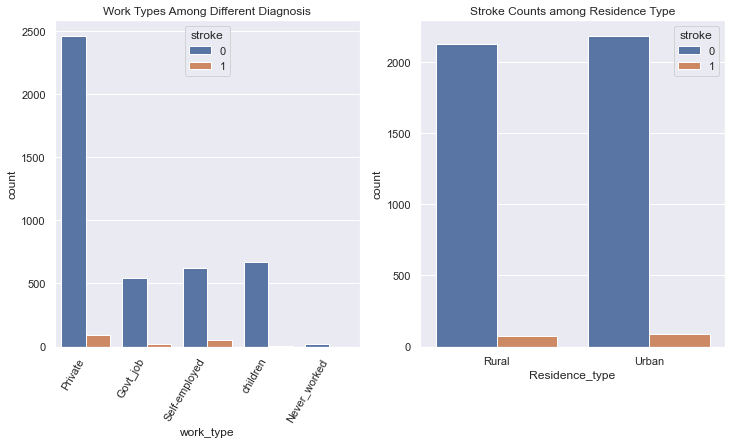

In [285]:
fig , (ax1,ax2) = plt.subplots(1,2, figsize=(12,6))
sns.countplot(x= 'work_type', hue= 'stroke', data=df, ax=ax1)
_ = ax1.set_xticklabels(labels = df['work_type'].unique(),rotation=60, ha='right')
ax1.set_title('Work Types Among Different Diagnosis')

sns.countplot(x= 'Residence_type', hue= 'stroke', data=df, ax = ax2)
_ = ax2.set_title('Stroke Counts among Residence Type')

plt.show()

Work Type : I don't know how things work in the country where the data gathered, But I assume private sector and running your own work is a stresfull thing to earn a position in competative environment, rather than government job. 

Residence : Seems where you live is not that important on having a stroke

# Scaling

In [286]:
from sklearn.preprocessing import LabelEncoder

In [287]:
lab_enc= LabelEncoder()

In [288]:
# Let's see (don't scroll back to top, lazy style) the columns to be encoded
for x in df.select_dtypes(include='object'):
    print(df[x].value_counts())

Female    2665
Male      1817
Other        1
Name: gender, dtype: int64
Yes    2801
No     1682
Name: ever_married, dtype: int64
Private          2553
children          675
Self-employed     669
Govt_job          564
Never_worked       22
Name: work_type, dtype: int64
Urban    2274
Rural    2209
Name: Residence_type, dtype: int64
never smoked       1633
Unknown            1441
formerly smoked     724
smokes              685
Name: smoking_status, dtype: int64


In [289]:
lab_enc_data= df.loc[:,['gender','ever_married','Residence_type','work_type','smoking_status']]
for x in lab_enc_data.columns:
    lab_enc_data[x]=lab_enc.fit_transform(lab_enc_data[x])

In [290]:
# I know this is the hard way, but i want to preserv the df and after append new columns after. 
# First remove these columns from df, then append lab_enc_data to the df. I will do this with a for loop
for x in lab_enc_data.columns:
    df[x]=lab_enc_data[x]

In [291]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,has_diabetes,is_obese
2,1,80.0,0,1,1,2,0,105.92,32.5,2,1,0,1
6,1,74.0,1,1,1,2,0,70.09,27.4,2,1,0,0
7,0,69.0,0,0,0,2,1,94.39,22.8,2,1,0,0
8,0,59.0,0,0,1,2,0,76.15,26.4,0,1,0,0
9,0,78.0,0,0,1,2,1,58.57,24.2,0,1,0,0


Appending completed.

One more thing to do. It would be better to handle earlier, but anyway. Let's investigate the normal distribution of the numeric data.

In [292]:
def bayesian_dist(column, data):
    """this function gets column name (str) and dataframe (str), 
    returns distribution plot of the column, skewness and kurtosis"""
    sns.distplot(data[column])
    plt.title(x)
    plt.show()
    plt.show()
    print('skewness: ', stats.skew(data[column]))
    print('kurtosis: ', stats.kurtosis(data[column]))
    

def normal_visual(column, df):
    """This function gets column and dataframe as str.
    Return 
    Shapiro Wilk test and Kolmogorov-Smirnov test results,
    distplot, skewness and kurtosis of the column
    """
    bayesian_dist(column, df)
    print('*'* 30)
    print(column, 'Shapiro-Wilk test t score: ', "{:.2f}".format(stats.shapiro(df[x])[0]))
    print(column, 'Shapiro-Wilk test p value: ', "{:.2f}".format(stats.shapiro(df[x])[1]))
    print('*'*30)
    print(column, 'Kolmogorov-Smirnov t score: ', "{:.2f}".format(stats.kstest(df[x],'norm', args=(df[x].mean(),
                                                                                                   df[x].std()))[0]))
    print(column, 'Kolmogorov-Smirnov t score: ', "{:.2f}".format(stats.kstest(df[x],'norm', args=(df[x].mean(),
                                                                                                   df[x].std()))[1]))
    
    

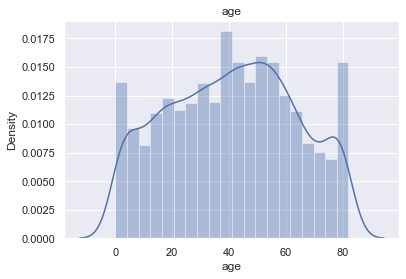

skewness:  -0.016774427253960552
kurtosis:  -0.9764296854578318
******************************
age Shapiro-Wilk test t score:  0.97
age Shapiro-Wilk test p value:  0.00
******************************
age Kolmogorov-Smirnov t score:  0.05
age Kolmogorov-Smirnov t score:  0.00


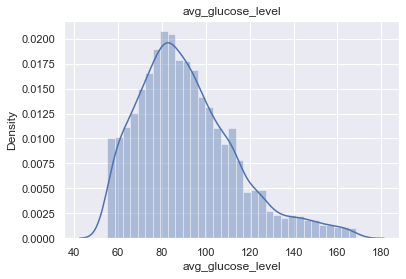

skewness:  0.8565344651093408
kurtosis:  0.6366830299415591
******************************
avg_glucose_level Shapiro-Wilk test t score:  0.95
avg_glucose_level Shapiro-Wilk test p value:  0.00
******************************
avg_glucose_level Kolmogorov-Smirnov t score:  0.06
avg_glucose_level Kolmogorov-Smirnov t score:  0.00


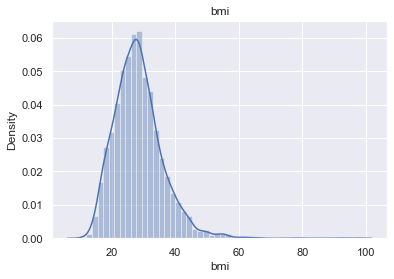

skewness:  1.1165411319267013
kurtosis:  4.1273983033803505
******************************
bmi Shapiro-Wilk test t score:  0.95
bmi Shapiro-Wilk test p value:  0.00
******************************
bmi Kolmogorov-Smirnov t score:  0.06
bmi Kolmogorov-Smirnov t score:  0.00


In [293]:
for x in means.columns:
    if x != 'stroke':
        normal_visual(x, df)

We will accept the data normally distributed if Skewness is in range -0.5,0.5 and Kurtosis -3,3

Skewness and kurtosis seem ok (except bmi), but histograms doesn't show normal dist. 

let's investigate p values. p>0.05 is accepted as Normal dist. So age and bmi might be normally distributed, however glucose level is not. Now let's see Kolmogorov-smirnov test results which is an other way to examine ND.

KS test results also indicate no ND of these data. 

We'll use Box-Cox transformation for these variables.

In [294]:
# boxcox transformation 

for x in means.columns:
    if x != 'stroke':
        means[x] = stats.boxcox(df[x])[0]

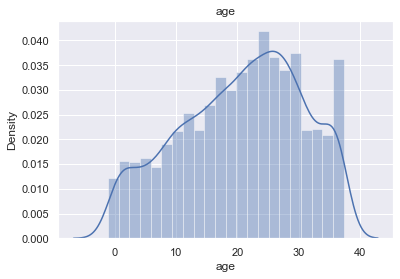

skewness:  -0.282584310784286
kurtosis:  -0.8210167786267726
******************************
age Shapiro-Wilk test t score:  0.97
age Shapiro-Wilk test p value:  0.00
******************************
age Kolmogorov-Smirnov t score:  0.06
age Kolmogorov-Smirnov t score:  0.00


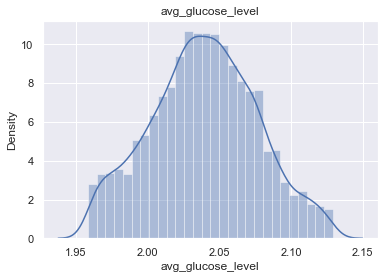

skewness:  0.014742031255685652
kurtosis:  -0.454481701221928
******************************
avg_glucose_level Shapiro-Wilk test t score:  0.99
avg_glucose_level Shapiro-Wilk test p value:  0.00
******************************
avg_glucose_level Kolmogorov-Smirnov t score:  0.02
avg_glucose_level Kolmogorov-Smirnov t score:  0.08


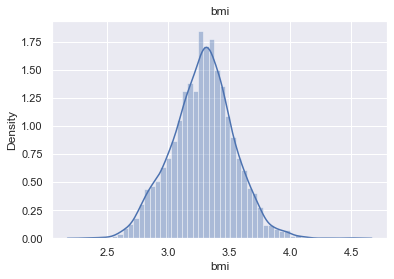

skewness:  -0.0001406568919835786
kurtosis:  0.30580878127793065
******************************
bmi Shapiro-Wilk test t score:  1.00
bmi Shapiro-Wilk test p value:  0.00
******************************
bmi Kolmogorov-Smirnov t score:  0.03
bmi Kolmogorov-Smirnov t score:  0.00


In [295]:
for x in means.columns:
    if x != 'stroke':
        normal_visual(x, means)

They seem ok for now. Now append these new columns to the df dataframe

In [296]:
for x in means.columns:
    if x != 'stroke':
        df[x]=means[x]

# and check if it's ok
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,has_diabetes,is_obese
2,1,36.601491,0,1,1,2,0,2.067519,3.449384,2,1,0,1
6,1,34.393760,1,1,1,2,0,2.001962,3.281726,2,1,0,0
7,0,32.522357,0,0,0,2,1,2.050331,3.101046,2,1,0,0
8,0,28.681967,0,0,1,2,0,2.016041,3.245189,0,1,0,0
9,0,35.869958,0,0,1,2,1,1.969773,3.159651,0,1,0,0


## Dealing with Class Imbalance with SMOTE

In [297]:
from sklearn.model_selection import train_test_split
target = df['stroke']
predictors = df.drop('stroke', axis=1)
x_train, x_test, y_train, y_test = train_test_split(predictors,target, train_size=0.7,
                                                    random_state= 42, stratify = target.values)


display(x_train.shape)
display(y_train.shape)
display(x_test.shape)
display(y_test.shape)

(3138, 12)

(3138,)

(1345, 12)

(1345,)

In [298]:
# SMOTE method for class imbalance, 
X = df.drop('stroke', axis=1)
y= df['stroke']
from imblearn.combine import SMOTEENN
oversample = SMOTEENN(random_state=42)
X_sm, y_sm = oversample.fit_resample(x_train,y_train)
print('Data shapes before oversampling were {0} and {1}'.format(x_train.shape, y_train.shape))
print('Data shapes after oversampling are {0} and {1}'.format(X_sm.shape, y_sm.shape))
y_sm.value_counts()

Data shapes before oversampling were (3138, 12) and (3138,)
Data shapes after oversampling are (5337, 12) and (5337,)


1    2911
0    2426
Name: stroke, dtype: int64

# Model Interpretation

In [300]:

from sklearn.metrics import accuracy_score

#ML algoritms
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier



#Performance metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

In [301]:
# Non-oversampled data ML
model_accuracy = pd.DataFrame(columns=['Model','Accuracy'])
models = {"LR": LogisticRegression(),
          "NB": GaussianNB(),
          "KNN" : KNeighborsClassifier(),
          "DT" : DecisionTreeClassifier(),
          'RFC' : RandomForestClassifier(),
          'ABC' : AdaBoostClassifier(),
          'GBC' : GradientBoostingClassifier(),
          'DTC' : DecisionTreeClassifier(),
          }

for test, clf in models.items():
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    acc = accuracy_score(y_test,y_pred)
    train_pred = clf.predict(x_train)
    train_acc = accuracy_score(y_train, train_pred)
    print( test + ' scores')
    print(acc)
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print('*' * 100)
    model_accuracy = model_accuracy.append({'Model': test, 'Accuracy': acc, 'Train_acc': train_acc}, ignore_index=True)

LR scores
0.9628252788104089
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1295
           1       0.00      0.00      0.00        50

    accuracy                           0.96      1345
   macro avg       0.48      0.50      0.49      1345
weighted avg       0.93      0.96      0.94      1345

[[1295    0]
 [  50    0]]
****************************************************************************************************
NB scores
0.8996282527881041
              precision    recall  f1-score   support

           0       0.97      0.92      0.95      1295
           1       0.12      0.26      0.16        50

    accuracy                           0.90      1345
   macro avg       0.54      0.59      0.55      1345
weighted avg       0.94      0.90      0.92      1345

[[1197   98]
 [  37   13]]
****************************************************************************************************
KNN scores
0.9605947955390335
  

In [302]:
model_accuracy

,Model,Accuracy,Train_acc
0,LR,0.962825,0.963352
1,NB,0.899628,0.894200
2,KNN,0.960595,0.964308
3,DT,0.933086,1.000000
4,RFC,0.962825,1.000000
5,ABC,0.961338,0.964627
6,GBC,0.962825,0.971638
7,DTC,0.932342,1.000000


Accuracy scores are good, ranging between 0.89 to 0.96. Seem's Ok right?

#### NO !!

Lets investigate the confusion matrices:

All models are good at predicting 'no stroke'. On the other hand , predicting 'Stroke' is on the ground.. However, the model needs to predict 'stroke' which is 4% in total population.  With these True negative predictions these models are useless. 

Let's try the models with oversampled data.


In [303]:
#resampled data train_test_split
resX_train, resX_test, resy_train, resy_test = train_test_split(X_sm, y_sm, train_size= 0.7,
                                                               random_state=42)

print(resX_train.shape, resX_test.shape)
print(resy_train.shape, resy_test.shape)

(3735, 12) (1602, 12)
(3735,) (1602,)


In [304]:
# oversampled data ML
model_accuracy = pd.DataFrame(columns=['Model','Accuracy'])
models = {"LR": LogisticRegression(),
          "NB": GaussianNB(),
          "KNN" : KNeighborsClassifier(),
          "DT" : DecisionTreeClassifier(),
          'RFC' : RandomForestClassifier(),
          'ABC' : AdaBoostClassifier(),
          'GBC' : GradientBoostingClassifier(),
          'DTC' : DecisionTreeClassifier(),
          }

for test, clf in models.items():
    clf.fit(resX_train, resy_train)
    y_pred = clf.predict(resX_test)
    acc = accuracy_score(resy_test,y_pred)
    train_pred = clf.predict(resX_train)
    train_acc = accuracy_score(resy_train, train_pred)
    print( test + ' scores')
    print(acc)
    print(classification_report(resy_test,y_pred))
    print(confusion_matrix(resy_test,y_pred))
    print('*' * 100)
    model_accuracy = model_accuracy.append({'Model': test, 'Accuracy': acc, 'Train_acc': train_acc}, ignore_index=True)

LR scores
0.8595505617977528
              precision    recall  f1-score   support

           0       0.88      0.81      0.84       749
           1       0.84      0.91      0.87       853

    accuracy                           0.86      1602
   macro avg       0.86      0.86      0.86      1602
weighted avg       0.86      0.86      0.86      1602

[[604 145]
 [ 80 773]]
****************************************************************************************************
NB scores
0.83645443196005
              precision    recall  f1-score   support

           0       0.92      0.71      0.80       749
           1       0.79      0.95      0.86       853

    accuracy                           0.84      1602
   macro avg       0.86      0.83      0.83      1602
weighted avg       0.85      0.84      0.83      1602

[[531 218]
 [ 44 809]]
****************************************************************************************************
KNN scores
0.9519350811485643
            

In [305]:
model_accuracy.sort_values('Accuracy', ascending=False)

,Model,Accuracy,Train_acc
4,RFC,0.974407,1.000000
2,KNN,0.951935,0.959839
7,DTC,0.950062,1.000000
3,DT,0.945693,1.000000
6,GBC,0.931960,0.948594
5,ABC,0.889513,0.891834
0,LR,0.859551,0.860509
1,NB,0.836454,0.835341


 ### Random Forest to go
 As we can see RFC has a accuracy score of 95%, and also precision-recall and f1-scores are 95%. By data oversampling, we handled Class Imbalance. 
 
 Let's try Hyperparameter Tuning for the RFC algoritm

In [306]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
rfc = RandomForestClassifier()


# number of estimators , default = 100
n_estimators = [int(x) for x in np.linspace(start=10, stop=100, num=10)]
# number of  features for every split, default= auto, we have options sqrt(same as auto), log2, None( = n_features)
max_features = ['auto','log2', 1,2,3]
#maximum depth for trees
max_depth = [2,4,6,8,10, None]
#min_samples_leaf
min_samples_leaf = [1,2]
#min_samples_split
min_samples_split = [2,5,10]
#bootstrap
bootstrap = [True, False]

#Create random grid
param_grid = {'n_estimators': n_estimators,
             'max_features' : max_features,
             'max_depth' : max_depth,
             'min_samples_leaf' : min_samples_leaf,
             'min_samples_split' : min_samples_split,
             'bootstrap' : bootstrap}



In [307]:
rf_grid = RandomizedSearchCV(estimator= rfc, param_distributions = param_grid, n_iter= 100,  cv=3, n_jobs=2, verbose=2)

In [308]:
rf_grid.fit(resX_train, resy_train)
rf_grid.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 90,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 2,
 'max_depth': None,
 'bootstrap': False}

In [309]:
# number of estimators , default = 100
n_estimators = [29,30,31]
# number of  features for every split, default= auto, we have options sqrt(same as auto), log2, None( = n_features)
max_features = [1,3,5]
#maximum depth for trees
max_depth = [ None, 2, 5]
#min_samples_leaf
min_samples_leaf = [1]
#min_samples_split
min_samples_split = [1,2,3]
#bootstrap
bootstrap = [False]

#Create random grid
param_grid = {'n_estimators': n_estimators,
             'max_features' : max_features,
             'max_depth' : max_depth,
             'min_samples_leaf' : min_samples_leaf,
             'min_samples_split' : min_samples_split,
             'bootstrap' : bootstrap}

In [310]:
gr_grid = GridSearchCV(estimator= rfc, param_grid = param_grid,cv=3, n_jobs=-1, verbose=2)

In [311]:
gr_grid.fit(resX_train, resy_train)
gr_grid.best_params_ , gr_grid.best_score_

Fitting 3 folds for each of 81 candidates, totalling 243 fits


({'bootstrap': False,
  'max_depth': None,
  'max_features': 5,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 30},
 0.9708165997322625)

We can see clearly best parameters for Random Forest Classifier model. 

In [312]:
rfc = RandomForestClassifier(bootstrap= False, max_depth=None, max_features= 3, min_samples_leaf = 1, 
                            min_samples_split=3, n_estimators= 31)
rfc.fit(resX_train, resy_train)
y_pred = rfc.predict(resX_test)
acc = accuracy_score(resy_test,y_pred)
print(acc)
print(accuracy_score(rfc.predict(resX_train), resy_train))
print(classification_report(resy_test, y_pred))
print(confusion_matrix(resy_test, y_pred))

0.980649188514357
1.0
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       749
           1       0.98      0.98      0.98       853

    accuracy                           0.98      1602
   macro avg       0.98      0.98      0.98      1602
weighted avg       0.98      0.98      0.98      1602

[[731  18]
 [ 13 840]]


### ROC Curves and AUC

Keeping on model evaluation.

In [313]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

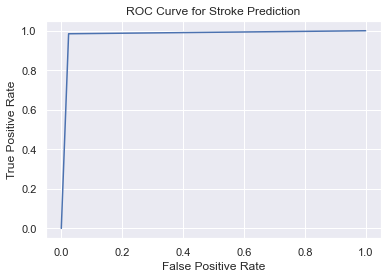

In [314]:
fpr, tpr, threshold = roc_curve(resy_test, y_pred)
plt.plot(fpr, tpr)
plt.title('ROC Curve for Stroke Prediction')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()



In [315]:
roc_auc_score(resy_test,y_pred)

0.9803638145115722

## Feature Importance evaluation

In [316]:
feature_imp = rfc.feature_importances_

In [317]:
feature_imp

array([0.02097191, 0.50359795, 0.01134726, 0.00709244, 0.0310137 ,
       0.08633838, 0.02509164, 0.07917827, 0.11789915, 0.0693902 ,
       0.01073621, 0.03734288])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'gender'),
  Text(1, 0, 'age'),
  Text(2, 0, 'hypertension'),
  Text(3, 0, 'heart_disease'),
  Text(4, 0, 'ever_married'),
  Text(5, 0, 'work_type'),
  Text(6, 0, 'Residence_type'),
  Text(7, 0, 'avg_glucose_level'),
  Text(8, 0, 'bmi'),
  Text(9, 0, 'smoking_status'),
  Text(10, 0, 'has_diabetes'),
  Text(11, 0, 'is_obese')])

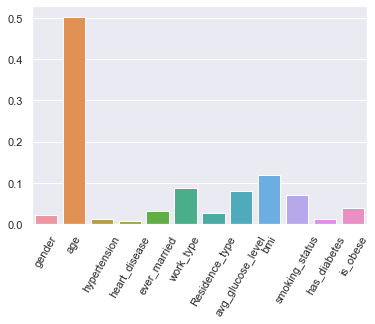

In [318]:
sns.barplot(resX_train.columns, feature_imp)
plt.xticks(rotation=60)

In [319]:
features = resX_train.loc[:,['age','work_type','Residence_type','avg_glucose_level','bmi','smoking_status','is_obese']]

In [320]:
resX_train, resX_test, resy_train, resy_test = train_test_split(features, resy_train, test_size=0.3, random_state=42)

In [321]:
rfc.fit(resX_train, resy_train)
y_pred = rfc.predict(resX_test)
acc = accuracy_score(resy_test,y_pred)
print(acc)
print(classification_report(resy_test, y_pred))
print(confusion_matrix(resy_test, y_pred))

0.9625334522747547
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       526
           1       0.95      0.98      0.97       595

    accuracy                           0.96      1121
   macro avg       0.96      0.96      0.96      1121
weighted avg       0.96      0.96      0.96      1121

[[496  30]
 [ 12 583]]


Feature importance didn't changed the model accuracy significantly. 

# Discussion

This was a good exercise for me , and I've learnt about BoxCox transformation, Class Imbalance and SMOTE and nearmiss method. And I also practiced my model interpretation,  bayesian distribution- skewness-kurtosis values, hyperparameter tuning and tried Feature Importance(way to go btw)

Anyways,
Random Forest Classification did a good job on predicting clients with Stroke. Not only accuracy scores are good, additionally Precision, Recall, F1-scores and ROC curve and AUC score are also good.

PS: 
I learned that I made a mistake using SMOTE on all the data. So I changed the process as follows:
Split the data into train and test datasets
Used SMOTEENN ;
    
    "This rule involves using k=3 nearest neighbors to locate those examples in a dataset that are misclassified and that are then removed. 
    It can be applied to all classes or just those examples in the majority class.

    Gustavo Batista, et al. explore many combinations of oversampling and undersampling methods compared to the methods used in isolation in their 2004 paper titled
     “A Study of the Behavior of Several Methods for Balancing Machine Learning Training Data.”

    This includes the combinations:

    Condensed Nearest Neighbors + Tomek Links
    SMOTE + Tomek Links
    SMOTE + Edited NearestNeighbors
    Regarding this final combination, the authors comment that ENN is more aggressive at downsampling the majority class than Tomek Links, 
    providing more in-depth cleaning. They apply the method, removing examples from both the majority and minority classes"

source : Jason Brownlee, Machine Learning Mastery blog [url](https://machinelearningmastery.com/combine-oversampling-and-undersampling-for-imbalanced-classification/)

Then trained the model and made a prediction.
 